Currently I'm thinking that while we're studying the various types of sources we would save a version of this notebook which focuses on each fault. 

In [109]:
%matplotlib inline
import os
import json
import codecs
import numpy as np

import matplotlib.pyplot as plt
import openquake.hazardlib.geo.geodetic as geo
import hmtk.sources as src
import hmtk.seismicity.declusterer as decluster
import hmtk.plotting.seismicity.catalogue_plots as cp

from copy import deepcopy
from hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
from hmtk.plotting.seismicity.completeness import plot_stepp_1972

from string import Template
from collections import OrderedDict
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser
from hmtk.seismicity.selector import CatalogueSelector

from hmtk.seismicity.occurrence.weichert import Weichert
from hmtk.seismicity.occurrence.aki_maximum_likelihood import AkiMaxLikelihood
from hmtk.seismicity.occurrence.b_maximum_likelihood import BMaxLikelihood
from hmtk.seismicity.occurrence.kijko_smit import KijkoSmit

# Catalogue and sources 
from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser

from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.plotting.seismicity.completeness import plot_stepp_1972
from hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment 
from hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence, 
                                                      get_completeness_adjusted_table,
                                                      _get_catalogue_bin_limits)

from hmtk.plotting.faults.geology_mfd_plot import plot_recurrence_models
from openquake.hazardlib.scalerel.wc1994 import WC1994

In [15]:
# Marmaris, Turkey
target_lon = 28.25
target_lat = 36.85

sources_file = "../geology/MarmarisDangerousSources11_300km.xml"

catalogue_filename = '../seismicity/Marmaris-catalogue1_homogenised_cleaned.csv'

In [8]:
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file() 

print 'Minimum magnitude: ', np.min(catalogue.data['magnitude'])
print 'Maximum magnitude: ', np.max(catalogue.data['magnitude'])
print 'Number of events: ', len(catalogue.data['magnitude'])
print 'Catalogue keys: '
print catalogue.data.keys()

Catalogue Attribute Identifier is not a recognised catalogue key
Minimum magnitude:  1.98
Maximum magnitude:  7.5
Number of events:  30546
Catalogue keys: 
['eventID', 'comment', 'sigmaMagnitude', 'hour', 'SemiMinor90', 'magnitude', 'Agency', 'second', 'longitude', 'month', 'depthError', 'flag', 'depth', 'magnitudeType', 'SemiMajor90', 'timeError', 'year', 'latitude', 'ErrorStrike', 'day', 'minute']


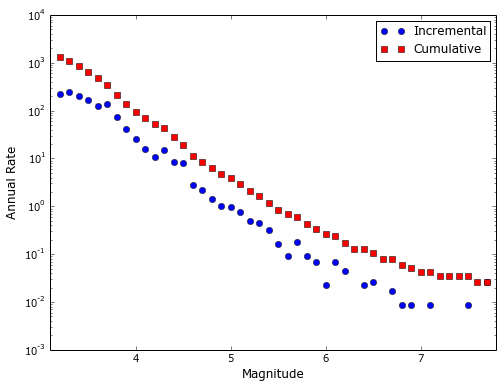

Completeness table guess
[[ 2004.      3.2]
 [ 1992.      4.3]
 [ 1972.      4.5]
 [ 1900.      6.5]]


In [9]:
completeness_table_guess = np.array([[2004, 3.2],
                                     [1992, 4.3], 
                                     [1972, 4.5], 
                                     [1900, 6.5]]) 
cp.plot_observed_recurrence(catalogue, completeness_table_guess, 0.1)
print 'Completeness table guess'
print completeness_table_guess

In [10]:
# identify clusters
declusterer = decluster.dec_gardner_knopoff.GardnerKnopoffType1()
decluster_config = {
    'time_distance_window': decluster.distance_time_windows.UhrhammerWindow(), 
    'fs_time_prop': 1.0}
cluster_index, cluster_flag = declusterer.decluster(catalogue, decluster_config)

# purge catalogue
declustered = deepcopy(catalogue)
mainshock_flag = cluster_flag == 0 
declustered.purge_catalogue(mainshock_flag)

In [11]:
# Map configuration
span = 1 # deg
map_config = {"min_lon": target_lon - 2*span, 
              "max_lon": target_lon + 2*span, 
              "min_lat": target_lat - span, 
              "max_lat": target_lat + span, "resolution": "l"}

In [16]:
# Reading the models 
parser = nrmlSourceModelParser(sources_file)

# Parse the seismic sources and save them in "source_model"
source_model = parser.read_file("Sources Around Marmaris")

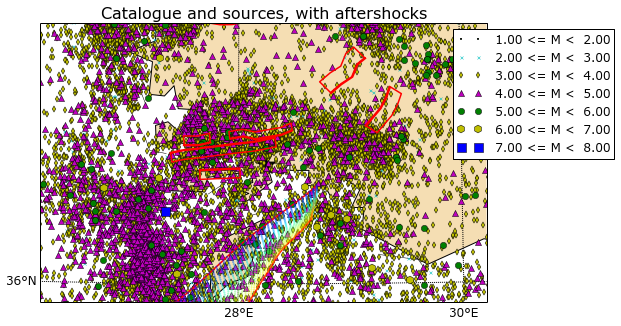

Number of events:  30546


In [18]:
my_map = HMTKBaseMap(map_config, 'Catalogue and sources, with aftershocks')
my_map.add_catalogue(catalogue, overlay=True)
my_map.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k')
print 'Number of events: ', len(catalogue.data['magnitude'])

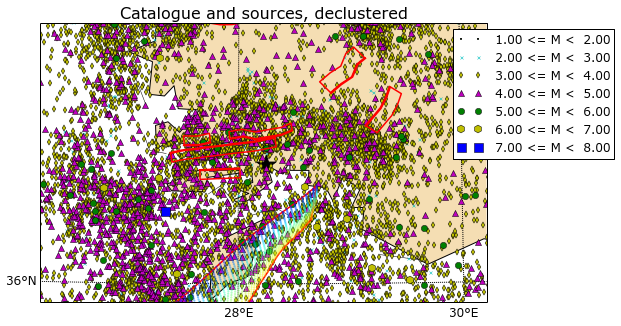

Number of events:  19049


In [21]:
my_map = HMTKBaseMap(map_config, 'Catalogue and sources, declustered')
my_map.add_catalogue(declustered, overlay=True)
my_map.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k')
print 'Number of events: ', len(declustered.data['magnitude'])

In [22]:
selector = CatalogueSelector(declustered, create_copy=True)

In [59]:
for source in source_model.sources:
    if isinstance(source, src.area_source.mtkAreaSource): 
        source.select_catalogue(selector)
        print 'Area source %s, name %s, # of events %8.0f' % (
            source.id, source.name, source.catalogue.get_number_events())
        #subcatalogue_area = selector.    

In [24]:
r_km = 10*np.ones_like(source_model.sources)
r_km[-1] = 30
for i, source in enumerate(source_model.sources):
    if isinstance(source, src.simple_fault_source.mtkSimpleFaultSource): 
        source.select_catalogue(selector, r_km[i])
    elif isinstance(source, src.complex_fault_source.mtkComplexFaultSource): 
        source.select_catalogue(selector, r_km[i]) 
        
    print '%s: %s, %d events wihin %g km' % (
        source.id, source.name, source.catalogue.get_number_events(), r_km[i])

TRCS394: Datca Horst North Boundary 1, 148 events wihin 10 km
TRCS391: Gokova Oren Fault Zone 1, 344 events wihin 10 km
TRCS331: Buyuk Menderes Graben North Boundary 2, 316 events wihin 10 km
TRCS271: Golgelidag Horst West Boundary - Tavas, 55 events wihin 10 km
TRCS322: Gediz Graben South Boundary, 165 events wihin 10 km
TRCS393: Gokova Oren Fault Zone 3, 191 events wihin 10 km
TRCS390: Aksu Thrust, 425 events wihin 10 km
TRCS268: Golgelidag Horst East Boundary - Akalan, 146 events wihin 10 km
TRCS913: Ula-Oren, 562 events wihin 10 km
TRCS330: Buyuk Menderes Graben North Boundary 1, 428 events wihin 10 km
HELL001: Hellenic Arc, 4235 events wihin 30 km


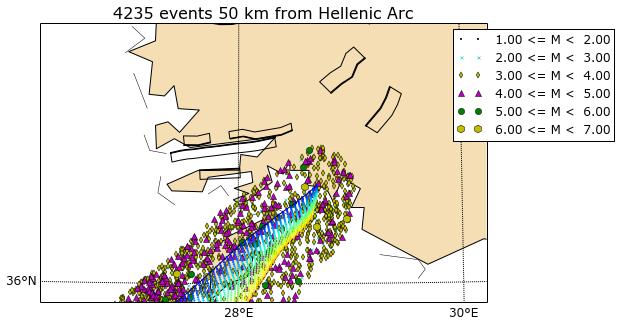

In [70]:
fault_id = 'HELL001'
r_km = 50
source = [source for source in source_model.sources if source.id == fault_id][0]
#for i, source in enumerate(source_model.sources):
n_events = source.catalogue.get_number_events()
# if n_events < 5: continue
basemap = HMTKBaseMap(
    map_config, '%d events %d km from %s' % (n_events, r_km, source.name))
basemap.add_catalogue(source.catalogue, overlay=True)
basemap.add_source_model(source_model, area_border='k-')

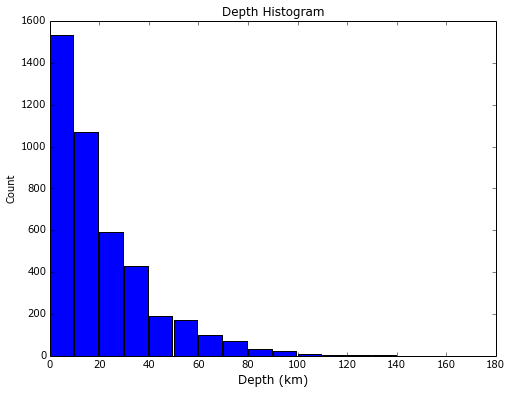

In [50]:
cp.plot_depth_histogram(source.catalogue, 10)

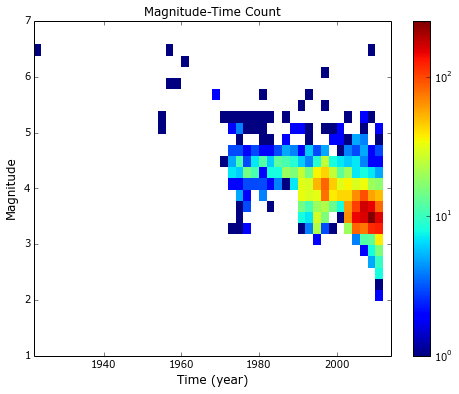

In [51]:
cp.plot_magnitude_time_density(source.catalogue, 0.2, 2)

In [108]:
# Set up the configuration parameterss
complete_config = {'magnitude_bin': 1.0, 'time_bin': 5.0, 
               'increment_lock': False}

# Calling the method
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(
    source.catalogue, complete_config)

completeness_table = completeness_table[~np.isnan(completeness_table).any(axis=1)]

# Print the completeness table
print 'Completeness table using Stepp method (1971)'
print np.round(completeness_table)


# Setting configuration for the completeness plot
#plot_stepp_1972.create_stepp_plot(completeness_algorithm,'output_data/Stepp_prueba.png' )


Completeness table using Stepp method (1971)
[[  2.01000000e+03   1.00000000e+00]
 [  2.00800000e+03   2.00000000e+00]
 [  1.99900000e+03   3.00000000e+00]
 [  1.97300000e+03   4.00000000e+00]
 [  1.95300000e+03   5.00000000e+00]]


In [110]:
completeness_table_guess = np.array([[2004, 3.2],
                                     [1992, 4.3], 
                                     [1972, 4.5], 
                                     [1900, 6.5]])

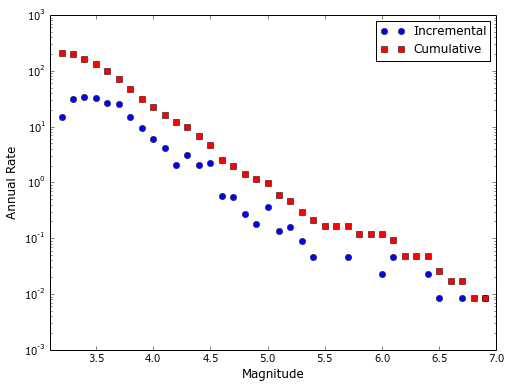

In [111]:

cp.plot_observed_recurrence(source.catalogue, completeness_table_guess, 0.1)

In [113]:
'''
Implements the maximum likelihood estimator of Weichert (1980)
'''

# Set up the configuration parameters
weichert_config = {'magnitude_interval': 0.2, 'bvalue': 1., 'itstab': 1E-5, 'maxiter': 1000}

recurrence = Weichert()

bval, sigmab, rate, sigmarate = recurrence.calculate(source.catalogue, weichert_config, completeness = completeness_table_guess)

print '\n'
print 'Weichert: ok'
print 'bval =', bval, 'sigmab =', sigmab, 'rate =', rate, 'sigmarate =', sigmarate
print '\n'



Weichert: ok
bval = 0.912297160505 sigmab = 0.0104968236289 rate = 5.25291409914 sigmarate = 0.00690357772762




In [116]:

# Set up fault parameters
slip = 4.0  # Slip rate in mm/yr

# Area = along-strike length (km) * down-dip with (km)
area = source.geometry.get_area()

# Rake = 0.
if source.rake >= 180:
    rake = source.rake - 360
else:
    rake = source.rake

# Magnitude Scaling Relation
msr = WC1994()

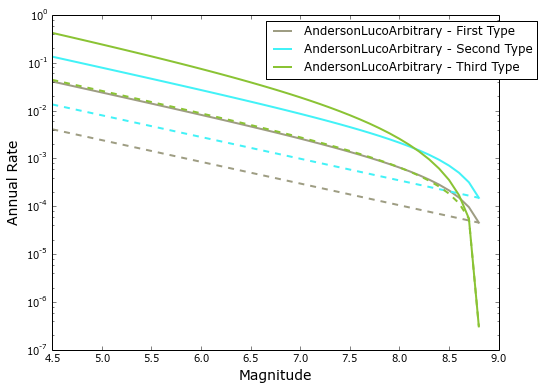

In [117]:
#Magnitude Frequency Distribution Example


anderson_luco_config1 = {'Model_Name': 'AndersonLucoArbitrary',
                         'Model_Type': 'First',
                         'Model_Weight': 1.0,  # Weight is a required key - normally weights should sum to 1.0 - current example is simply illustrative! 
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [0.454, 0.05]}
anderson_luco_config2 = {'Model_Name': 'AndersonLucoArbitrary',
                         'Model_Type': 'Second',
                         'Model_Weight': 1.0,
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [0.454, 0.05]}
anderson_luco_config3 = {'Model_Name': 'AndersonLucoArbitrary',
                         'Model_Type': 'Third',
                         'Model_Weight': 1.0,   
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [0.454, 0.05]}
# Create a list of the configurations
anderson_luco_arb = [anderson_luco_config1, anderson_luco_config2, anderson_luco_config3]

# View the corresponding magnitude recurrence model
plot_recurrence_models(anderson_luco_arb, area, slip, msr, rake, msr_sigma=0.0)

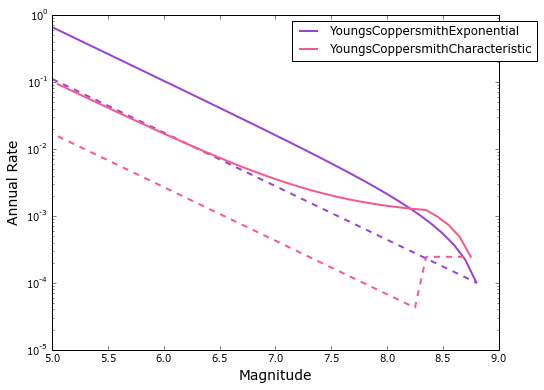

In [118]:
exponential = {'Model_Name': 'YoungsCoppersmithExponential',
               'MFD_spacing': 0.1,
               'Maximum_Magnitude': None,
               'Maximum_Magnitude_Uncertainty': None,
               'Minimum_Magnitude': 5.0,
               'Model_Weight': 1.0,
               'b_value': [0.8, 0.1]}

hybrid = {'Model_Name': 'YoungsCoppersmithCharacteristic',
          'MFD_spacing': 0.1,
          'Maximum_Magnitude': None,
          'Maximum_Magnitude_Uncertainty': None,
          'Minimum_Magnitude': 5.0,
          'Model_Weight': 1.0,
          'b_value': [0.8, 0.1],
          'delta_m': None}

youngs_coppersmith = [exponential, hybrid]

# View the corresponding magnitude recurrence model
plot_recurrence_models(youngs_coppersmith, area, slip, msr, rake, msr_sigma=0.0)